In [2]:
print("Starting Experiments!")
import torch

import torch.nn.functional as F
import torch.nn as nn
import torch.distributed as dist

import torch_geometric
import torch_geometric.nn as gnn

from torch_geometric.datasets import QM9
import GCL.augmentors
import GCL.augmentors as A

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, mean_squared_error, r2_score
from sklearn.linear_model import RidgeClassifierCV, LogisticRegression, LinearRegression
import itertools

import GCL.augmentors as A
import edge_removing as A_alternate
from GCL.augmentors import node_dropping, ppr_diffusion, feature_dropout, edge_adding, rw_sampling
import matplotlib.pyplot as plt

import math
import pandas as pd


device = 'cuda' if torch.cuda.is_available else 'cpu'


Starting Experiments!


In [3]:
parameters = {}
parameters['batch_size'] = 4096


In [4]:
whole_dataset = QM9(root = 'data/')

xenonpy_tr_df = pd.read_csv('XenonPy_transformed_datasets/QM9/xenon_tr.csv')
xenonpy_val_df = pd.read_csv('XenonPy_transformed_datasets/QM9/xenon_val.csv')
xenonpy_test_df = pd.read_csv('XenonPy_transformed_datasets/QM9/xenon_test.csv')


#print(whole_dataset.get_summary())
#print(dir(whole_dataset))
#print(whole_dataset.len())

tr_ratio = 0.9
val_ratio = 0.09
test_ratio = 0.01


n = whole_dataset.len()
tr_n = math.floor(tr_ratio*n) # Number of QM9 to use as training data
val_n = math.floor(val_ratio*n)
test_n = math.floor(test_ratio*n)


all_inds = range(n)
tr_inds, val_inds = train_test_split(all_inds, train_size = tr_n, random_state = 24)
val_test_inds = range(n - tr_n)
val_inds, test_inds = train_test_split(val_test_inds, train_size = val_n, random_state = 24)


train_sampler = torch.utils.data.SubsetRandomSampler(tr_inds)
val_sampler = torch.utils.data.SubsetRandomSampler(val_inds)

# We need to make a train and validation set since QM9 does not provide them
train_set = torch.utils.data.Subset(whole_dataset, tr_inds)
val_set = torch.utils.data.Subset(whole_dataset, val_inds)

train_loader = torch_geometric.loader.DataLoader(train_set, batch_size = parameters['batch_size'],
                                                shuffle = True, num_workers = 2,)
                                                #sampler = train_sampler)
big_train_loader = torch_geometric.loader.DataLoader(train_set, batch_size = int(1e9),
                                                shuffle = True, num_workers = 2,)

val_loader = torch_geometric.loader.DataLoader(val_set, batch_size=2048,
                                            shuffle=False, num_workers=2,)
                                              #sampler = val_sampler)
    
val_aug = A.RandomChoice([], num_choices = 0)

In [5]:
print(xenonpy_tr_df.iloc[3:6])

   Unnamed: 0  ave:atomic_number  ave:atomic_radius  ave:atomic_radius_rahm  \
3           3          -0.121393           0.698131               -0.923622   
4           4          -0.525358           0.479430               -0.965579   
5           5          -0.063684          -0.219104                0.128428   

   ave:atomic_volume  ave:atomic_weight  ave:boiling_point  ave:bulk_modulus  \
3           1.143538          -0.144046          -1.348992          1.468031   
4           0.259024          -0.539803          -0.669851          0.888846   
5          -0.228068          -0.060032           0.250155         -0.292111   

   ave:c6_gb  ave:covalent_radius_cordero  ...  min:num_s_valence  min:period  \
3  -1.200473                    -0.531147  ...          -0.017243   -0.017243   
4  -0.981044                    -0.806505  ...          -0.017243   -0.017243   
5   0.197823                     0.035240  ...          -0.017243   -0.017243   

   min:specific_heat  min:thermal_con

In [6]:
qm9_index = {0: 'Dipole moment',
1: 'Isotropic polarizability',
2: 'Highest occupied molecular orbital energy',
3: 'Lowest unoccupied molecular orbital energy',
4: 'Gap between previous 2',
5: 'Electronic spatial extent',
6: 'Zero point vibrational energy',
7: 'Internal energy at 0K',
8: 'Internal energy at 298.15K',
9: 'Enthalpy at 298.15K',
10: 'Free energy at 298.15K',
11: 'Heat capavity at 298.15K',
12: 'Atomization energy at 0K',
13: 'Atomization energy at 298.15K',
14: 'Atomization enthalpy at 298.15K',
15: 'Atomization free energy at 298.15K',
16: 'Rotational constant A',
17: 'Rotational constant B',
18: 'Rotational constant C',}

print(qm9_index.items())

dict_items([(0, 'Dipole moment'), (1, 'Isotropic polarizability'), (2, 'Highest occupied molecular orbital energy'), (3, 'Lowest unoccupied molecular orbital energy'), (4, 'Gap between previous 2'), (5, 'Electronic spatial extent'), (6, 'Zero point vibrational energy'), (7, 'Internal energy at 0K'), (8, 'Internal energy at 298.15K'), (9, 'Enthalpy at 298.15K'), (10, 'Free energy at 298.15K'), (11, 'Heat capavity at 298.15K'), (12, 'Atomization energy at 0K'), (13, 'Atomization energy at 298.15K'), (14, 'Atomization enthalpy at 298.15K'), (15, 'Atomization free energy at 298.15K'), (16, 'Rotational constant A'), (17, 'Rotational constant B'), (18, 'Rotational constant C')])


In [7]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.rep_dim = 128
        self.emb_dim = 256
        
        # Data under graph
        self.conv1 = GCNConv(whole_dataset.num_node_features, self.rep_dim // 2)
        self.bn1 = nn.BatchNorm1d(self.rep_dim // 2)
        self.a1 = nn.LeakyReLU(0.02)
        
        self.conv2 = GCNConv(self.rep_dim // 2, self.rep_dim) # To Rep Space
        self.bn2 = nn.BatchNorm1d(self.rep_dim)
        
        # Projection to representation
        self.mpool1 = gnn.global_mean_pool
        #self.fc1 = nn.Linear(self.rep_dim, self.rep_dim)
        
        # Graph 2
        self.conv3 = GCNConv(self.rep_dim, self.rep_dim * 2) # To Emb Space
        self.bn3 = nn.BatchNorm1d(self.rep_dim * 2)
        
        # Projection to embedding
        #self.mpool2 = gnn.global_mean_pool
        #self.fc2 = nn.Linear(self.emb_dim, self.emb_dim) # Linear to rep?
        
    def forward(self, data, binds):
        x = data[0].float().to(device)
        edge_index = data[1].to(device)
        
        x = self.conv1(x, edge_index)
        x = self.a1(self.bn1(x))
        x = F.dropout(x, training=self.training)
        
        x = self.bn2(self.conv2(x, edge_index))
        
        x_rep = self.mpool1(x, binds)
        
        x_emb = self.conv3(x, edge_index)
        return x_rep, x_emb



def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

def VicRegLoss(x, y):
    # https://github.com/facebookresearch/vicreg/blob/4e12602fd495af83efd1631fbe82523e6db092e0/main_vicreg.py#L184
    # x, y are output of projector(backbone(x and y))
    
    # These are the default params used in natural image vicreg
    sim_coeff = 25
    std_coeff = 25
    cov_coeff = 1
    
    
    repr_loss = F.mse_loss(x, y)

    x = x - x.mean(dim=0)
    y = y - y.mean(dim=0)

    std_x = torch.sqrt(x.var(dim=0) + 0.0001)
    std_y = torch.sqrt(y.var(dim=0) + 0.0001)
    std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

    cov_x = (x.T @ x) / (parameters['batch_size'] - 1)
    cov_y = (y.T @ y) / (parameters['batch_size'] - 1)
    cov_loss = off_diagonal(cov_x).pow_(2).sum().div(
        x.shape[1]
    ) + off_diagonal(cov_y).pow_(2).sum().div(x.shape[1])
    
    # self.num_features -> rep_dim?
    loss = (
        sim_coeff * repr_loss
        + std_coeff * std_loss
        + cov_coeff * cov_loss
    )
    return loss


def train(parameters):
    
    device = 'cuda'

    model = GCN().to(device)
    n_epochs = 20

    
    row_ind = 0
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=5e-4)
    transfer_mat = torch.zeros((len(qm9_index.keys()), 6))

    tr_losses = []
    val_losses = []

    for epoch in range(0,n_epochs+1):
        epoch_losses = []
        for batch in train_loader:
            optimizer.zero_grad()

            batch_inds = batch.batch.to(device)

            # batch of graphs has edge attribs, node attribs - (n_nodes, n_features+1) -> concat (n_nodes, attrib1)

            batch.x = batch.x.float()#.to(device)
            #batch.edge_index = batch.edge_index.to(device)

            # Barlow - get 2 random views of batch
            #print(batch.x, batch.edge_index, batch.edge_attr)
            #print(aug, type(aug))
            b1 = aug(batch.x, batch.edge_index, batch.edge_attr)
            b2 = aug(batch.x, batch.edge_index, batch.edge_attr)

            # Embed each batch (ignoring representations)
            r1, e1 = model(b1, batch_inds)
            r2, e2 = model(b2, batch_inds)

            loss = VicRegLoss(e1, e2)
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.data.item())

        print('epoch train loss', sum(epoch_losses) / len(epoch_losses))
        tr_losses.append(sum(epoch_losses) / len(epoch_losses))

        if epoch % 4 == 0:

            # Downstream supervised loss
            
#             for batch in big_train_loader: # take entire train set
#                 with torch.no_grad():
#                     # Embed training set under model
#                     rep_tr, _ = model(val_aug(batch.x, batch.edge_index, batch.edge_attr), batch.batch.to(device))


#                     for val_batch in val_loader:
#                         # Embed validation set under model
#                         rep_val, _ = model(val_aug(val_batch.x, val_batch.edge_index, val_batch.edge_attr), val_batch.batch.to(device))

#                         # For each task in QM9
#                         for tar_ind in range(batch.y.shape[1]):
#                             # Fit a model on model representation of train set

#                             #print(rep_tr.shape, batch.y[tar_ind].shap)
#                             lm = LinearRegression().fit(rep_tr.cpu(), batch.y[:,tar_ind])
#                             # Test the model on model repersentation of val set
#                             tar_yhat = lm.predict(rep_val.cpu())
#                             mse_met = mean_squared_error(val_batch.y[:,tar_ind], tar_yhat).item()
#                             r2_met = r2_score(val_batch.y[:,tar_ind], tar_yhat)
#                             #print(qm9_index[tar_ind], mse_met, r2_met)
#                             transfer_mat[tar_ind, row_ind] = mse_met
#                         row_ind += 1

            # VicReg Validation Loss
            val_loss = []
            for batch in val_loader:
                with torch.no_grad():
                    # VicReg validation loss
                    b1 = aug(batch.x, batch.edge_index, batch.edge_attr)
                    b2 = aug(batch.x, batch.edge_index, batch.edge_attr)
                    r1, e1 = model(b1, batch.batch.to(device))
                    r2, e2 = model(b2, batch.batch.to(device))

                    val_loss.append(VicRegLoss(e1, e2).item())

            val_losses.append(torch.mean(torch.FloatTensor(val_loss)))

    #plt.plot(tr_losses)
    plt.plot(val_losses, label = parameters['aug_str'])
    
    return model, tr_losses, val_losses, transfer_mat

import os

def trymkdir(path):
    if os.path.exists(path):
        pass
    else:
        os.mkdir(path)

<GCL.augmentors.augmentor.RandomChoice object at 0x7fff1e651190> <class 'GCL.augmentors.augmentor.RandomChoice'>
['NodeDropping', 'FeatureMasking', 'EdgeRemoving', 'EdgeAdding']
[(0, 0, 0, 1), (0, 0, 1, 0), (0, 1, 0, 0), (1, 0, 0, 0)]
aug_index:  (0, 0, 0, 1)
tr_strs:  EdgeAdding


/home/ewvertina/anaconda3/envs/molecular_modelling/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


epoch train loss 2163060.9547413792
epoch train loss 244190.67618534484
epoch train loss 116319.63820043103
epoch train loss 76512.09779094828
epoch train loss 52420.18918372845
epoch train loss 35444.48309536638
epoch train loss 27506.079303609913
epoch train loss 21880.27670393319
epoch train loss 17459.540628367457
epoch train loss 13805.241497171337
epoch train loss 12532.847033270475
epoch train loss 13308.837848531788
epoch train loss 8507.898951037178
epoch train loss 9645.487708782328
epoch train loss 6864.263301454741
epoch train loss 6194.2123013200435
epoch train loss 6073.679527545797
epoch train loss 5951.064991918103
epoch train loss 5540.966552734375
epoch train loss 4184.069979963631
epoch train loss 3901.244393184267
aug_index:  (0, 0, 1, 0)
tr_strs:  EdgeRemoving
epoch train loss 2355181.182112069
epoch train loss 280053.9919181034
epoch train loss 111937.10802801725
epoch train loss 70122.61173221983
epoch train loss 50776.60829741379
epoch train loss 40847.298053609

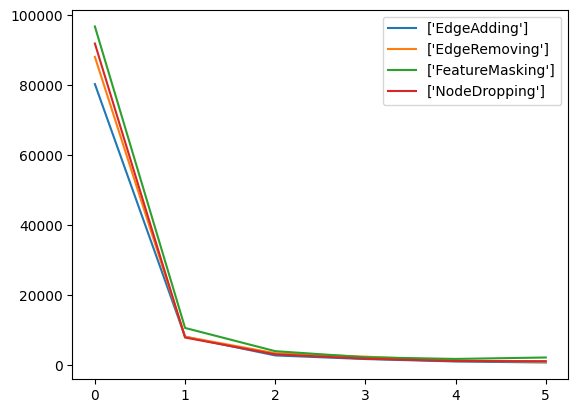

In [8]:
# Here is sample code for how to implement an "ablation" of 2-at-a-time augmentations
import GCL.augmentors as A
from GCL.augmentors import node_dropping, ppr_diffusion, feature_dropout, edge_adding, rw_sampling

aug = A.RandomChoice([#A.RWSampling(num_seeds=1000, walk_length=10),
                      A.NodeDropping(pn=0.1),
                      A.FeatureMasking(pf=0.1),
                      A.EdgeRemoving(pe=0.1)],
                     num_choices=1)

print(aug, type(aug))

# From a set of augmentations of length n_augmentations
aug_set = [A.NodeDropping(pn=0.1), A.FeatureMasking(pf=0.1), A.EdgeRemoving(pe=0.1), A.EdgeAdding(pe=0.1)]
           #ppr_diffusion, feature_dropout, edge_adding, rw_sampling]
    #A.PPRDiffusion()
aug_strs = ['NodeDropping', 'FeatureMasking', 'EdgeRemoving', 'EdgeAdding']
print(aug_strs)

# First get all pairs of indexes on-off in a list of length n_augmentations
aug_inds = list(itertools.product([0, 1], repeat=len(aug_set)))
aug_inds = [x for x in aug_inds if sum(x)==1]
print(aug_inds)

# Then for each augmentation, train and test a VicReg model trained under that augment
parameters = {}
parameters['batch_size'] = 64
parameters['learning_rate'] = 0.002
# etc parameters here which define model, hparams

for aug_index in aug_inds:
    print("aug_index: ", aug_index)
    tr_augs = []
    tr_strs = []
    for ind, augi in enumerate(aug_index):
        if augi == 1:
            tr_augs.append(aug_set[ind])
            tr_strs.append(aug_strs[ind])
            
    print("tr_strs: ", tr_strs[0])

    trymkdir(f'aug_sweep1/{tr_strs[0]}')
    
    tr_aug = A.RandomChoice(tr_augs, num_choices = 1)
    
    #print(tr_aug, type(tr_aug))
    parameters['train_aug'] = tr_aug
    parameters['aug_str'] = tr_strs
    
    model, train_loss, val_loss, transfer_mat = train(parameters)
    #transfer_scores = transfer_score(model, parameters)
    
    #print(transfer_mat)
    torch.save(model.state_dict(), f'aug_sweep1/{tr_strs[0]}/model.pt')
    torch.save(train_loss,  f'aug_sweep1/{tr_strs[0]}/train_loss.pt')
    torch.save(val_loss,  f'aug_sweep1/{tr_strs[0]}/val_loss.pt')
    torch.save(transfer_mat,  f'aug_sweep1/{tr_strs[0]}/transfer_mat.pt')
    
plt.legend()
plt.show()
    

['NodeDropping', 'FeatureMasking', 'EdgeRemoving', 'EdgeAdding']
[(0, 1, 1, 1), (1, 0, 1, 1), (1, 1, 0, 1), (1, 1, 1, 0)]
['FeatureMasking', 'EdgeRemoving', 'EdgeAdding']
epoch train loss 2524931.072198276
epoch train loss 379561.341325431
epoch train loss 143758.9827586207
epoch train loss 86663.8565463362
epoch train loss 66193.9542025862
epoch train loss 47774.93069773707
epoch train loss 37125.57940463362
epoch train loss 30533.29684132543
epoch train loss 22391.435109105605
epoch train loss 21421.849727235993
epoch train loss 18143.542194234913
epoch train loss 13309.172902074353
epoch train loss 13063.288203798491
epoch train loss 10499.981411637931
epoch train loss 10654.407967403018
epoch train loss 11437.7421875
epoch train loss 9462.65715079472
epoch train loss 8292.262855266703
epoch train loss 6002.863735856681
epoch train loss 5512.371615705819
epoch train loss 6274.913439520474
['NodeDropping', 'EdgeRemoving', 'EdgeAdding']
epoch train loss 2166517.900323276
epoch train l

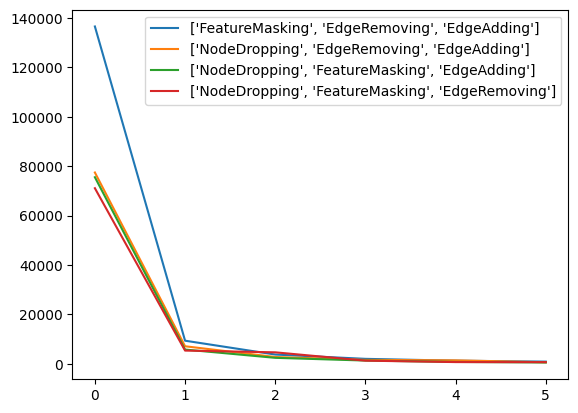

In [9]:
# Here is sample code for how to implement an "ablation" of 2-at-a-time augmentations


# From a set of augmentations of length n_augmentations
aug_set = [A.NodeDropping(pn=0.1), A.FeatureMasking(pf=0.1), A.EdgeRemoving(pe=0.1), A.EdgeAdding(pe=0.1)]
           #ppr_diffusion, feature_dropout, edge_adding, rw_sampling]
    #A.PPRDiffusion()
aug_strs = ['NodeDropping', 'FeatureMasking', 'EdgeRemoving', 'EdgeAdding']
print(aug_strs)

# First get all pairs of indexes on-off in a list of length n_augmentations
aug_inds = list(itertools.product([0, 1], repeat=len(aug_set)))
aug_inds = [x for x in aug_inds if sum(x)==3]
print(aug_inds)

# Then for each augmentation, train and test a VicReg model trained under that augment
parameters = {}
parameters['batch_size'] = 64
parameters['learning_rate'] = 0.002

experiment = 'aug_sweep3-4'
trymkdir(experiment)
# etc parameters here which define model, hparams

for aug_index in aug_inds:

    tr_augs = []
    tr_strs = []
    for ind, augi in enumerate(aug_index):
        if augi == 1:
            tr_augs.append(aug_set[ind])
            tr_strs.append(aug_strs[ind])
            
    print(tr_strs)
    trymkdir(f'{experiment}/{tr_strs}')
    
    tr_aug = A.RandomChoice(tr_augs, num_choices = 1)
    
    #print(tr_aug, type(tr_aug))
    parameters['train_aug'] = tr_aug
    parameters['aug_str'] = tr_strs
    
    model, train_loss, val_loss, transfer_mat = train(parameters)
    #transfer_scores = transfer_score(model, parameters)
    
    #print(transfer_mat)
    torch.save(model.state_dict(), f'{experiment}/{tr_strs}/model.pt')
    torch.save(train_loss,  f'{experiment}/{tr_strs}/train_loss.pt')
    torch.save(val_loss,  f'{experiment}/{tr_strs}/val_loss.pt')
    torch.save(transfer_mat,  f'{experiment}/{tr_strs}/transfer_mat.pt')
    
plt.legend()
plt.show()

[tensor(91948.1875), tensor(7814.8452), tensor(3009.2869), tensor(1763.7557), tensor(1088.7344), tensor(1056.0781)]
[tensor(96832.3203), tensor(10564.7383), tensor(3919.0598), tensor(2166.3093), tensor(1695.2609), tensor(2108.7307)]
[tensor(88121.9062), tensor(8051.5376), tensor(3328.2844), tensor(2346.0129), tensor(1234.2540), tensor(880.7978)]
[tensor(80350.8672), tensor(8060.2729), tensor(2698.4485), tensor(1664.4634), tensor(968.0049), tensor(680.8496)]


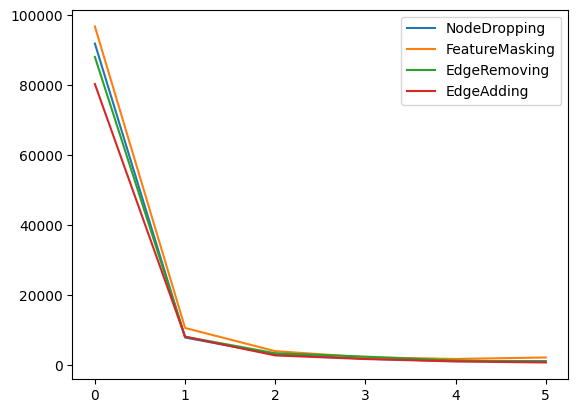

In [16]:
mse_scores = torch.zeros((19, len(aug_strs)))
for i_str, stri in enumerate(aug_strs):
    vec = torch.load(f'aug_sweep1/{stri}/val_loss.pt')
    
    model = GCN().to(device)
    model.load_state_dict(torch.load(f'aug_sweep1/{stri}/model.pt'))
    
    plt.plot(vec, label = stri)
    print(vec)
    
    for batch in big_train_loader: # take entire train set
        with torch.no_grad():
            # Embed training set under model
            rep_tr, _ = model(val_aug(batch.x, batch.edge_index, batch.edge_attr), batch.batch.to(device))
            if torch.cuda.is_available():
                rep_tr = rep_tr.to("cpu")
            rep_tr = pd.DataFrame(rep_tr.numpy())
            rep_tr.join(xenonpy_tr_df)

            val_tracker = 0
            for val_batch in val_loader:
                # Embed validation set under model
                rep_val, _ = model(val_aug(val_batch.x, val_batch.edge_index, val_batch.edge_attr), val_batch.batch.to(device))
                if torch.cuda.is_available():
                    rep_val = rep_val.to("cpu")
                rep_val = pd.DataFrame(rep_val.numpy())
                rep_val.join(xenonpy_val_df.iloc[val_tracker:(val_tracker+2048)])
                
                
                # For each task in QM9
                for tar_ind in range(batch.y.shape[1]):
                    # Fit a model on model representation of train set

                    #print(rep_tr.shape, batch.y[tar_ind].shap)
                    lm = LinearRegression().fit(rep_tr, batch.y[:,tar_ind])
                    # Test the model on model repersentation of val set
                    tar_yhat = lm.predict(rep_val)
                    mse_met = mean_squared_error(val_batch.y[:,tar_ind], tar_yhat).item()
                    r2_met = r2_score(val_batch.y[:,tar_ind], tar_yhat)
                    #print(qm9_index[tar_ind], mse_met, r2_met)
                    mse_scores[tar_ind, i_str] = mse_met
                    
                val_tracker += 2048
    
plt.legend()
plt.show()

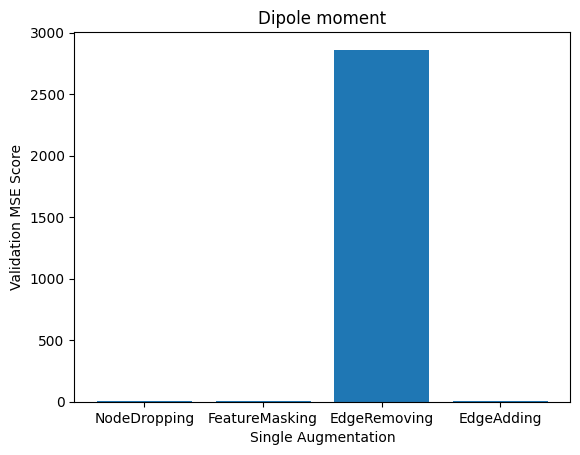

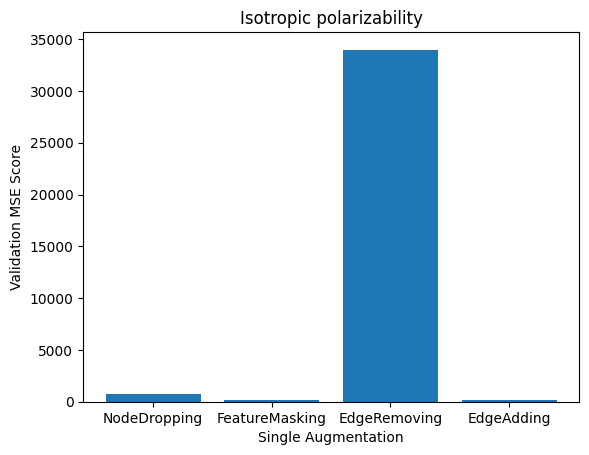

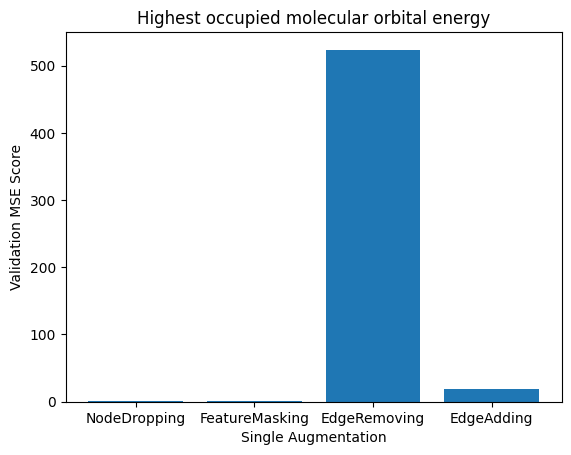

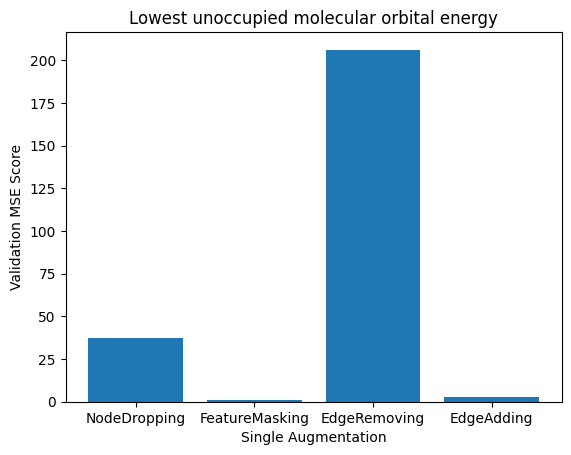

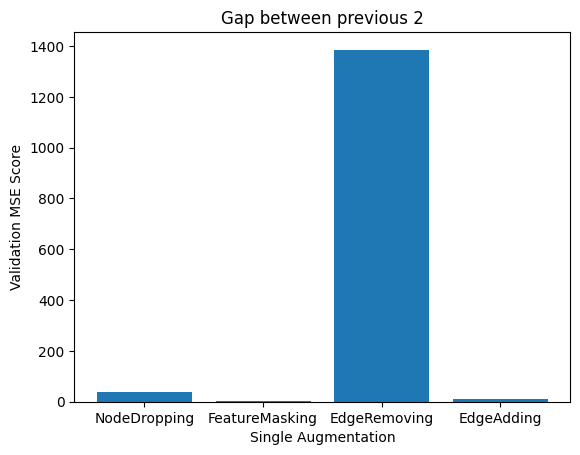

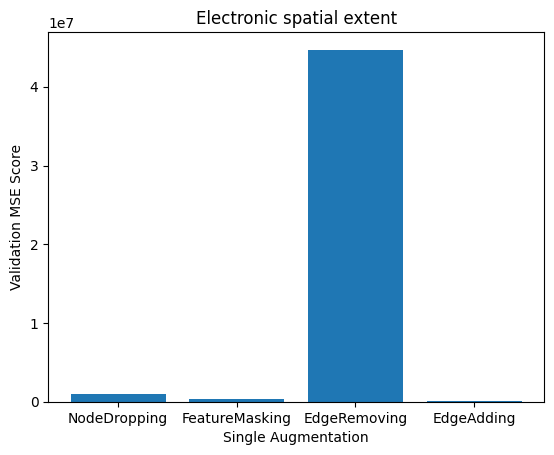

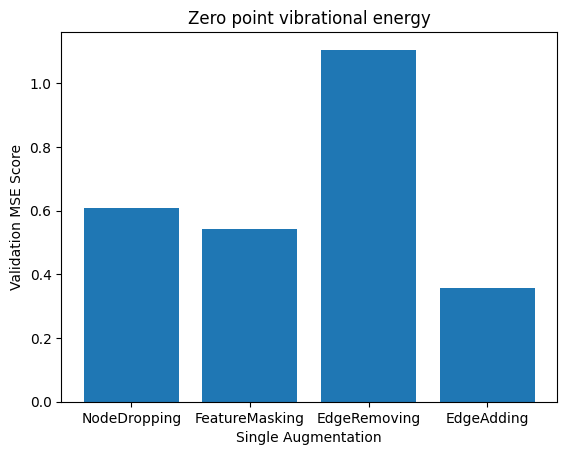

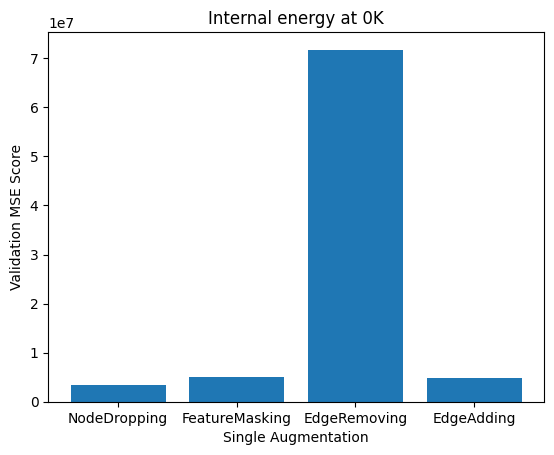

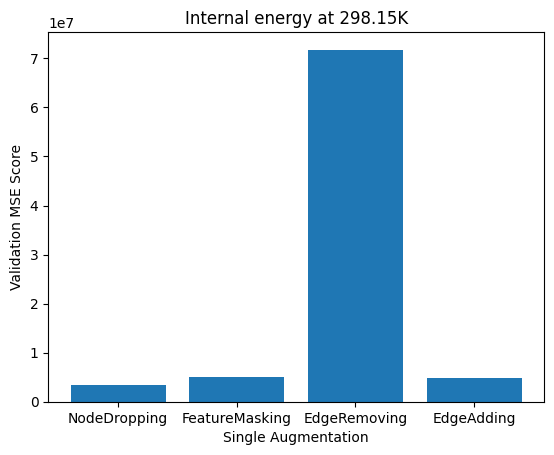

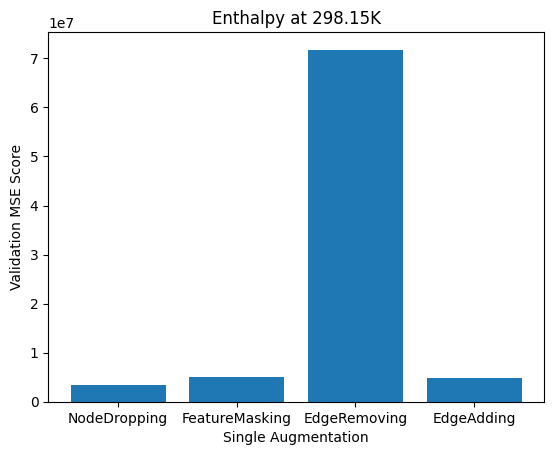

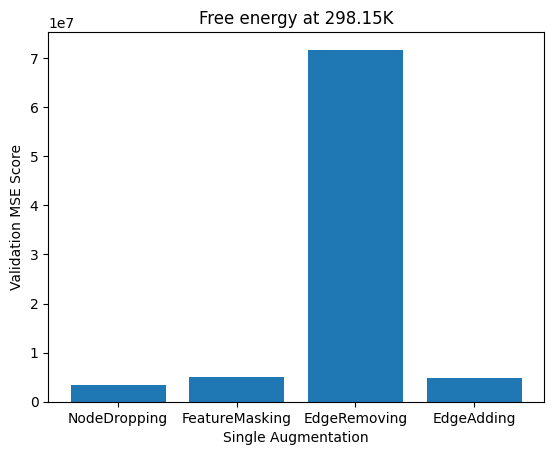

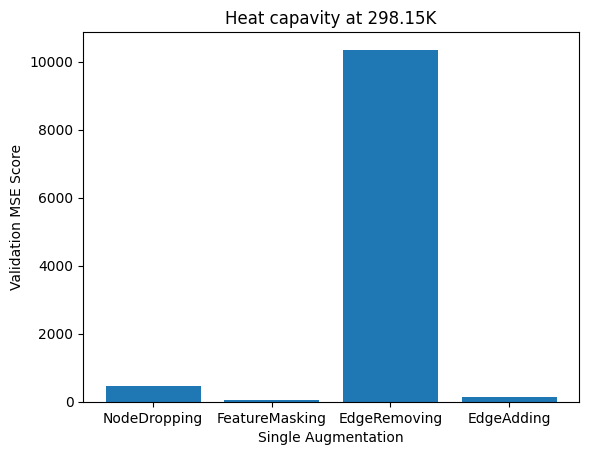

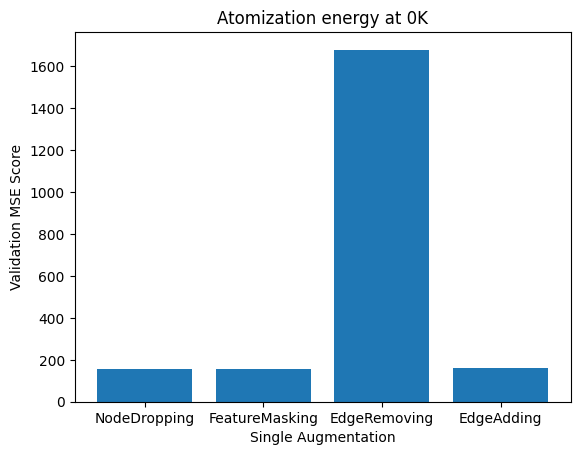

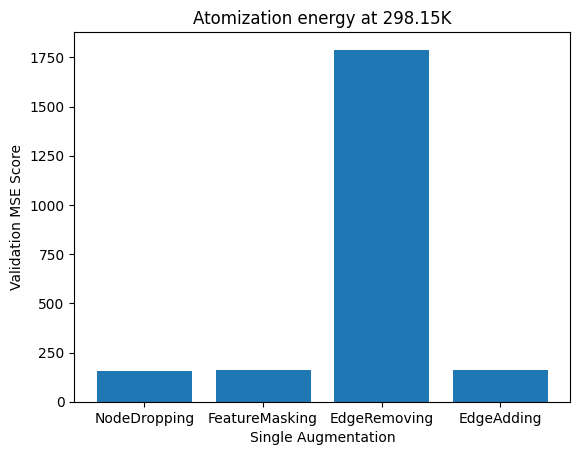

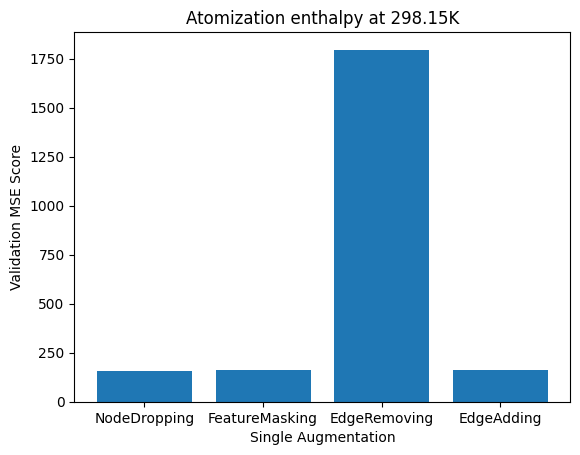

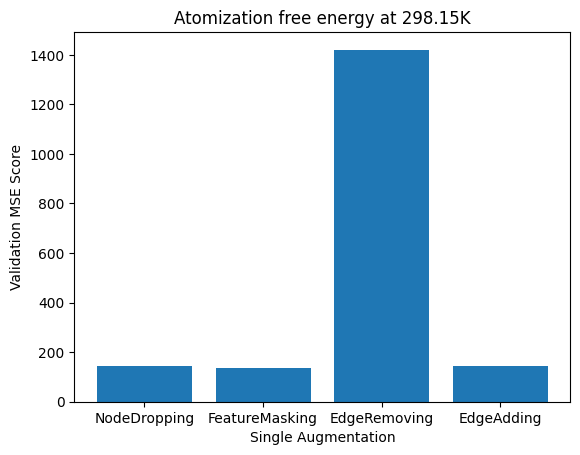

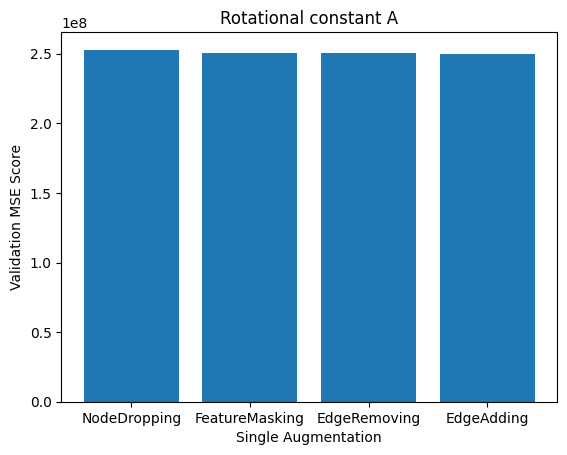

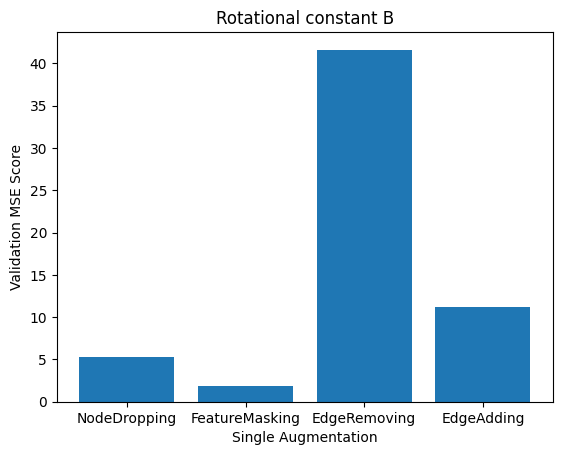

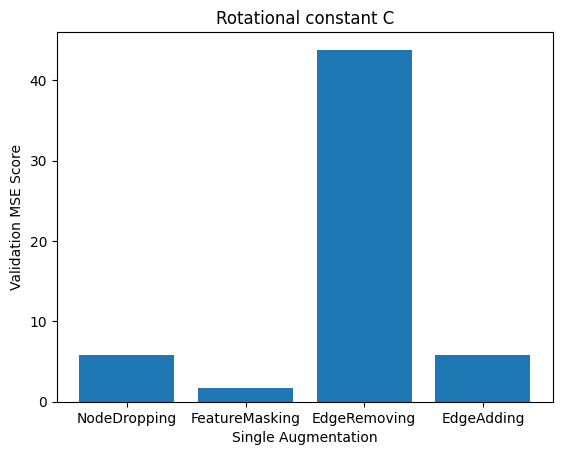

In [17]:
#print(mse_scores, mse_scores.shape)

# For one score, 

for i, row in enumerate(mse_scores):
    name = qm9_index[i]
    
    plt.bar(x = range(len(row)), height = row)
    plt.xticks(range(len(row)), aug_strs)
    plt.xlabel('Single Augmentation')
    plt.ylabel('Validation MSE Score')
    plt.title(name)
    plt.show()

In [ ]:
# For all-but-one-augmentation
mse_scores = torch.zeros((19, len(aug_strs)))

#augs = os.walk('aug_sweep3-4')
print(next(os.walk('aug_sweep3-4'))[1])

for i_str, stri in enumerate(next(os.walk('aug_sweep3-4'))[1]):
    vec = torch.load(f'aug_sweep3-4/{stri}/val_loss.pt')
    
    model = GCN().to(device)
    model.load_state_dict(torch.load(f'aug_sweep3-4/{stri}/model.pt'))
    
    plt.plot(vec, label = stri)
    print(vec)
    
    for batch in big_train_loader: # take entire train set
        with torch.no_grad():
            # Embed training set under model
            rep_tr, _ = model(val_aug(batch.x, batch.edge_index, batch.edge_attr), batch.batch.to(device))
            rep_tr.join(xenonpy_tr_df)
            
            val_tracker = 0
            for val_batch in val_loader:
                # Embed validation set under model
                rep_val, _ = model(val_aug(val_batch.x, val_batch.edge_index, val_batch.edge_attr), val_batch.batch.to(device))
                rep_val.join(xenonpy_val_df.iloc[val_tracker:(val_tracker+2048)])
              
            
                # For each task in QM9
                for tar_ind in range(batch.y.shape[1]):
                    # Fit a model on model representation of train set

                    #print(rep_tr.shape, batch.y[tar_ind].shap)
                    lm = LinearRegression().fit(rep_tr.cpu(), batch.y[:,tar_ind])
                    # Test the model on model repersentation of val set
                    tar_yhat = lm.predict(rep_val.cpu())
                    mse_met = mean_squared_error(val_batch.y[:,tar_ind], tar_yhat).item()
                    r2_met = r2_score(val_batch.y[:,tar_ind], tar_yhat)
                    #print(qm9_index[tar_ind], mse_met, r2_met)
                    mse_scores[tar_ind, i_str] = mse_met
                
                val_tracker += 2048
    
plt.legend()
plt.show()

#print(mse_scores, mse_scores.shape)

# For one score, 

In [ ]:
# I would also add a column for "naive estimator"
# This could be a simple regressor, or a mean estimator (like Eric)

for i, row in enumerate(mse_scores):
    name = qm9_index[i]
    
    plt.bar(x = range(len(row)), height = row)
    plt.xticks(range(len(row)), ['NOT '+x for x in aug_strs], rotation = -30)
    plt.xlabel('Augmentation')
    plt.ylabel('Validation MSE Score')
    plt.title(name)
    
    plt.savefig(f'imgs/3-4_{qm9_index[i]}.png', bbox_inches = 'tight')
    plt.savefig(f'imgs/3-4_{qm9_index[i]}.pdf', bbox_inches = 'tight')
    plt.show()
    



In [ ]:
# Further step would be summarizing the average ranks of the models to summarize 19 QM's into 1 rank
import scipy.stats as ss
# For each QM9_index, find the min of the row -> this index is the best augmentation
print('PLEASE NOTE THESE ARE RANKS INTEGERS NOT INDEXES:')

ranks = []
for i, row in enumerate(mse_scores):
    elem = torch.argmin(row).item()
    
    # For each element of the qm9 row, 
    rank = ss.rankdata(row)
    
    ranks.append(torch.FloatTensor(rank))
    
ranks = torch.stack(ranks)
print(ranks.shape)
meanranks= torch.mean(ranks, dim = 0)
print(meanranks)

plt.bar(range(4), meanranks)
plt.xticks(range(4), ['NOT '+x for x in aug_strs], rotation = -30)
plt.ylabel('Average Rank')
plt.xlabel('Augmentation')
plt.title('Average Augmentation Rank Across Transfer Tasks')
plt.savefig(f'imgs/3-4_{qm9_index[i]}.png', bbox_inches = 'tight')
plt.savefig(f'imgs/3-4_{qm9_index[i]}.pdf', bbox_inches = 'tight')
plt.show()